# Automatisierung der Fallauswahl

Meine manuelle Fallauswahl enthält nur einen sehr kleinen Anteil idealer Fälle. Eventuell geht das automatisch besser.

In [1]:
import numpy as np
import xarray as xr
from standard_config import *
import glob
import pandas as pd

from plotting_tools.colormaps import radar_cmap as rc

from io_tools import radolan
import load_satellite_data as lsd
import read_linet_data as rld
import datetime as dt
import MSGtools as mst
from analysis_tools import grid_and_interpolation as gi

import matplotlib.pyplot as plt
%matplotlib inline

import radar_cmap as rc
rcmap,rnorm = rc.radar_cmap()

import haci_filters as hf

/vols/talos/local/anaconda2-5.0.0/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
proj_path = "/vols/satellit/home/lenk/proj"

In [4]:
good_cases_2013 = pd.read_csv("{}/2019-01_trackingstudie/data/haci_cases_2013_filtered.csv".format(proj_path))

In [5]:
def convert_haci_bbox2msg(object_data,box_size=35):
    from io_tools import radolan
    from analysis_tools import grid_and_interpolation as gi
    
    r = radolan.Radolan()
    slon,slat = mst.get_msg_lon_lat('eu')
    
    centroid_line = object_data.l00 + (object_data.l01 - object_data.l00) / 2.
    centroid_column = object_data.c00 + (object_data.c01 - object_data.c00) / 2.
    
    centroid_lon = r.lon[int(np.rint(centroid_line)),int(np.rint(centroid_column))]
    centroid_lat = r.lat[int(np.rint(centroid_line)),int(np.rint(centroid_column))]
    
    sat_row, sat_col = gi.get_index((centroid_lon,centroid_lat),slon,slat)
    sat_row_min = np.clip(sat_row - (box_size // 2),0,900)
    sat_row_max = np.clip(sat_row + (box_size // 2) + 1,0,900)
    sat_col_min = np.clip(sat_col - (box_size // 2),0,900)
    sat_col_max = np.clip(sat_col + (box_size // 2) + 1,0,900)
    
    sat_lon_min = slon[sat_row_min,sat_col_min]
    sat_lat_min = slat[sat_row_max,sat_col_min]
    sat_lon_max = slon[sat_row_max,sat_col_max]
    sat_lat_max = slat[sat_row_min,sat_col_max]
    
    out_dict = {'lon_min':sat_lon_min,
                'lat_min':sat_lat_min,
                'lon_max':sat_lon_max,
                'lat_max':sat_lat_max,
                'row_min':sat_row_min,
                'row_max':sat_row_max,
                'col_min':sat_col_min,
                'col_max':sat_col_max}
    
    return out_dict    

Als nächstes erzeugen wir uns Ausschnitte rund um die Startpunkte und berechnen den Bewölkungsgrad. Eventuell können wir die Fälle danach einteilen.

In [ ]:
plt.switch_backend("Agg")

In [6]:
cloudiness = dict()

for i, case in good_cases_2013.iterrows():
    try:
        case_id = "{}_{}".format(case.date.replace("-",""),case.id)
        sat_coords = convert_haci_bbox2msg(case,17)
        
        time = pd.Timestamp("{}T{}".format(case.date.replace("-",""),case.time))
        sat_data = lsd.load_satellite_data(time.to_pydatetime(),'HRV')

        rmn = sat_coords['row_min']*3
        rmx = sat_coords['row_max']*3
        cmn = sat_coords['col_min']*3
        cmx = sat_coords['col_max']*3
        
        sat_data_cutout = sat_data[rmn:rmx,cmn:cmx]

        cloudy = len(sat_data_cutout[np.where(sat_data_cutout>=0.3)])
        clear = len(sat_data_cutout[np.where(sat_data_cutout<0.3)])
        
        fig, ax = plt.subplots(1,1,figsize=(5,5))
        ax.imshow(sat_data_cutout,vmin=0,vmax=1,cmap='gray')
        plt.savefig("{}/2019-01_trackingstudie/pics/cutout_t0/{}.png".format(proj_path,case_id))
        plt.close()

        cloudiness[case_id] = cloudy / float(cloudy + clear)   
    except:
        continue

Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/02/07/msg?-sevi-20130207t1215z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hrit/2013/02/07/msg?-sevi-20130207t1215z-l15hrit-rss.c2.tar  does not exist!
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Reg

/home/lenk/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))


Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/05/30/msg?-sevi-20130530t1350z-l15hdf-rss-eu.c2.h5  does not exist!
... reading  /tmp/hrit3179334672/H-000-MSG2__-MSG2_RSS____-HRV______-000020___-201305301350-__
... reading  /tmp/hrit3179334672/H-000-MSG2__-MSG2_RSS____-HRV______-000021___-201305301350-__
... reading  /tmp/hrit3179334672/H-000-MSG2__-MSG2_RSS____-HRV______-000022___-201305301350-__
... reading  /tmp/hrit3179334672/H-000-MSG2__-MSG2_RSS____-HRV______-000023___-201305301350-__

Combine segments

Do calibration
Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/05/31/msg?-sevi-20130531t0830z-l15hdf-rss-eu.c2.h5  does not exist!
... reading  /tmp/hrit7313966739/H-000-MSG2__-MSG2_RSS____-HRV______-000020___-201305310830-__
... reading  /tmp/hrit7313966739/H-000-MSG2__-MSG2_RSS____-HRV______-000021___-201305310830-__
... reading  /tmp/hrit7313966739/H-000-MSG2__-MSG2_RSS____-HRV______

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region s

In [7]:
cloudiness

{'20130313_605': 0.028480725623582767,
 '20130319_581': 0.3722448979591837,
 '20130321_408': 0.8363718820861678,
 '20130410_347': 0.5325170068027211,
 '20130410_629': 0.9343310657596372,
 '20130410_687': 0.5272562358276645,
 '20130412_575': 0.3814965986394558,
 '20130416_446': 0.2980498866213152,
 '20130416_522': 0.2708390022675737,
 '20130416_549': 0.3330612244897959,
 '20130416_565': 0.43727891156462584,
 '20130416_593': 0.45732426303854873,
 '20130416_607': 0.4634013605442177,
 '20130416_611': 0.8713832199546485,
 '20130416_724': 0.09741496598639456,
 '20130416_731': 0.0707482993197279,
 '20130418_587': 0.46929705215419504,
 '20130418_602': 0.2595918367346939,
 '20130418_688': 0.1513832199546485,
 '20130418_722': 0.11201814058956916,
 '20130418_731': 0.19011337868480727,
 '20130418_773': 0.02820861678004535,
 '20130418_784': 0.03374149659863945,
 '20130427_610': 0.396734693877551,
 '20130504_1036': 0.27392290249433104,
 '20130504_723': 0.7600907029478458,
 '20130504_856': 0.86811791

In [15]:
cl_df = pd.DataFrame({'cloudiness':cloudiness.values(),
                      'case_id':cloudiness.keys()},index=np.arange(0,len(cloudiness.values())))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb67a142cd0>]],
      dtype=object)

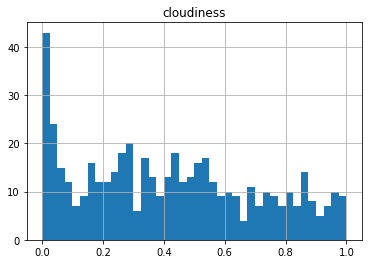

In [19]:
cl_df.hist('cloudiness',bins=40)

In [20]:
cl_df[cl_df.cloudiness<=0.2]

,case_id,cloudiness
6,20131105_419,0.034376
15,20130730_313,0.191202
17,20130812_139,0.138050
19,20130620_679,0.196553
21,20130620_675,0.130522
26,20130701_73,0.001179
27,20130818_656,0.046259
33,20130806_351,0.108844
35,20130615_1130,0.042812
36,20130725_191,0.184580


In [22]:
35//2

17